In [5]:
import librosa
import librosa.display
import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt
from pydub import AudioSegment
import json
import pandas as pd

C:\Users\isakg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


## PLAY AROUND WITH LIBRARY APIs

In [6]:
audio_path = 'data/genres_original/hiphop/hiphop.00005.wav'
x , sr = librosa.load(audio_path)#x is an audio time series as a numpy array. sr is the sampling rate
ipd.Audio(audio_path)

C:\Users\isakg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\librosa\util\decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


FileNotFoundError: [Errno 2] No such file or directory: 'data/genres_original/hiphop/hiphop.00005.wav'

In [3]:
song_path = 'data/genres_original/hiphop/hiphop.00001.wav'
#AudioSegment will allow us to split .wav files into multiple .wav files
#This is how we will get more data--> split one song (30 seconds) in 6 audios (each of 5 seconds )
splited_song = []
for w in range(0,6):
    t1 = 5*(w)*1000
    t2 = 5*(w+1)*1000
    newAudio = AudioSegment.from_wav(song_path)
    splited_song.append(newAudio[t1:t2])
    
splited_song[0].export('data/data_fiveSeconds/hiphop/hiphop.00001_5seconds.wav', format="wav")#this saves the new audio in a folder  
splited_song[0]   

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

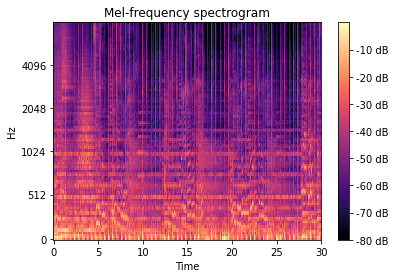

In [73]:
audio_path = 'data/genres_original/rock/rock.00050.wav'
x , sr = librosa.load(audio_path)
mel_spec = librosa.feature.melspectrogram(y=x, sr=sr, S=None)#MEL SPECTROGRAM

fig, ax = plt.subplots()
S_dB = librosa.power_to_db(mel_spec, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

[Text(0.5, 1.0, 'Spectrogram')]

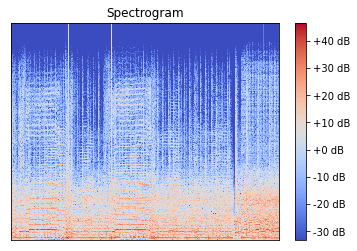

In [6]:
fig, ax = plt.subplots()#NORMAL SPECTROGRAM
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
img = librosa.display.specshow(Xdb)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Spectrogram')

## CREATE A DATASET

In [5]:
def thirty_into_five(path, genre):
    files = librosa.util.find_files(path, ext=['wav'])#this returns the entire path for each file in a genre folder.
    
    for song in files:
        song_path  = path[:70]+'/'+song[71+len(genre):]#song is a string that describe the entire path of the file,
                                                       #path[:70] is the same string for each song, for each genre.       
                                                       #song[71+len(genre) is the name of the song.

        for w in range(0,6):#this for loop splits each song into 6 audios
            t1 = 5*(w)*1000
            t2 = 5*(w+1)*1000
            newAudio = AudioSegment.from_wav(song_path)
            new = newAudio[t1:t2]
            new.export('data/data_fiveSeconds/'+genre+'/'+song[71+len(genre):-4]+'_'+str(t1)[:2]+'_'+str(t2)[:2]+'.wav',
                       format="wav")

def create_dataset(path, genre_list, dataset):
    
    row = 0
    for genre in genre_list:
        files = librosa.util.find_files(path+genre, ext=['wav'])#this returns the entire path for each file in a genre folder
        
        for song in files:
            x , sr = librosa.load(song)
            mel_spec = librosa.feature.melspectrogram(y=x, sr=sr, S=None)#MEL SPECTROGRAM
            mfcc = librosa.feature.mfcc(y=x, sr=sr, n_mfcc=13)
            song_id = song[71+len(genre)+1:-4]
            dataset['song_id'][row] = song_id
            dataset['song_timeSeries'][row] = x #row vector with len = 110250. 
            dataset['MFCCs'][row] = np.transpose(mfcc) #array of dimension (216, 13)
            dataset['Mel_spectrograms'][row] = mel_spec #array of dimension (128, 216)
            dataset['sampling_rate'][row] = sr # should be the same for every song, equal to 22050
            dataset['label'][row] = genre
            row+=1
            
    return dataset
        


##### Split each song into 6 audios and save them in the different folders depending on the genre

In [6]:
#thirty_into_five('data/genres_original/hiphop', 'hiphop')        
#thirty_into_five('data/genres_original/blues', 'blues')
#thirty_into_five('data/genres_original/classical', 'classical')
#thirty_into_five('data/genres_original/country', 'country')
#thirty_into_five('data/genres_original/disco', 'disco')
#thirty_into_five('data/genres_original/jazz', 'jazz')
#thirty_into_five('data/genres_original/metal', 'metal')
#thirty_into_five('data/genres_original/pop', 'pop')
#thirty_into_five('data/genres_original/reggae', 'reggae')
#thirty_into_five('data/genres_original/rock', 'rock')

#### Create a dataset with columns: Genre, mel-spectrogram, sampling rate

In [7]:
dataset = {'song_id':{}, 'song_timeSeries':{}, 'MFCCs':{}, 'Mel_spectrograms':{}, 'sampling_rate':{}, 'label':{}}
path = 'data/data_fiveSeconds/'
genre_list = ['jazz', 'rock', 'hiphop', 'metal', 'pop', 'disco', 'blues', 'classical', 'country', 'reggae']
data_diz = create_dataset(path, genre_list, dataset)  

In [8]:
df = pd.DataFrame(data_diz)
df = df.sample(frac = 1) #Shuffle the order of the rows. 
df.to_pickle("DataSet.pkl")
df.head()

,song_id,song_timeSeries,MFCCs,Mel_spectrograms,sampling_rate,label
3859,blues.00044_10_15,"[-0.17849731, -0.19042969, -0.23043823, -0.221...","[[-123.8312, 72.91271, 7.270915, 36.103386, -4...","[[3.648404, 6.016201, 14.328819, 15.766433, 6....",22050,blues
5487,reggae.00015_20_25,"[0.12704468, 0.091308594, 0.13565063, 0.060729...","[[-147.8802, 38.52575, 35.396908, 31.15145, -1...","[[0.29710823, 0.18769342, 0.1368317, 0.1483459...",22050,reggae
1277,hiphop.00013_50_10,"[0.006164551, -0.018066406, -0.051635742, -0.0...","[[-102.256836, 131.78409, 4.608823, 14.214663,...","[[0.6611498, 2.5814266, 2.8712232, 1.62308, 0....",22050,hiphop
3797,blues.00033_50_10,"[-0.16964722, -0.16500854, -0.15234375, -0.158...","[[-200.92526, 115.39553, 27.497993, 18.098671,...","[[0.04843872, 0.008646259, 6.0668066e-05, 7.91...",22050,blues
700,rock.00017_25_30,"[-0.15847778, -0.16201782, -0.14788818, -0.161...","[[-15.925279, 112.18059, -15.551596, 38.70349,...","[[5.0158224, 5.8674974, 5.1519966, 2.9040391, ...",22050,rock


## LOAD THE DATASET AND IMPLEMENT THE CNN

In [14]:
DATA = pd.read_pickle("DataSet.pkl")